In [22]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def load_data_comp_train():
    train = pd.read_csv('../data/train.csv')
    client = pd.read_csv('../data/client.csv')
    electricity_prices = pd.read_csv('../data/electricity_prices.csv')
    forecast_weather = pd.read_csv('../data/forecast_weather.csv')
    gas_prices = pd.read_csv('../data/gas_prices.csv')
    historical_weather = pd.read_csv('../data/historical_weather.csv')

    return (train, client, electricity_prices, forecast_weather,
            gas_prices, historical_weather)


def load_data_comp_test():
    test = pd.read_csv('../data/example_test_files/test.csv')
    client_test = pd.read_csv('../data/example_test_files/client.csv')
    electricity_prices_test = pd.read_csv('../data/example_test_files/electricity_prices.csv')
    forecast_weather_test = pd.read_csv('../data/example_test_files/forecast_weather.csv')
    gas_prices_test = pd.read_csv('../data/example_test_files/gas_prices.csv')
    historical_weather_test = pd.read_csv('../data/historical_weather.csv')

    return (test, client_test, electricity_prices_test, forecast_weather_test,
            gas_prices_test, historical_weather_test)


def graficar_ts(data, date_time, target_column, freq = 'M'):
    train_time = data[[date_time, target_column]].copy()
    train_time[date_time] = pd.to_datetime(train[date_time])
    train_time.index = train_time[date_time]
    train_time.drop(date_time, axis=1, inplace=True)
    # Agrupar por mes y calcular el resumen (por ejemplo, la suma)
    resumen_mensual = train_time.resample(freq).sum()
    # Graficar
    resumen_mensual.plot()
    plt.title('Resumen Mensual')
    plt.xlabel('Mes')
    plt.ylabel('Valor')
    plt.show()
    return

In [3]:
train, client, electricity_prices, forecast_weather, gas_prices, historical_weather = load_data_comp_train()
test, client_test, electricity_prices_test, forecast_weather_test, gas_prices_test, historical_weather_test = load_data_comp_test()

# Análisis descriptivo

En esta sección realizaremos un análisis descriptivo de los datos de enefit, para entender su relacion y cómo construir nuevas variables para los modelos

## Train

Iniciamos con la descripción del conjunto de entrenamiento

In [12]:
train.describe()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,3.218746e+02,1.009176e+06,3.304538e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826343e+02,5.826482e+05,1.959059e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01


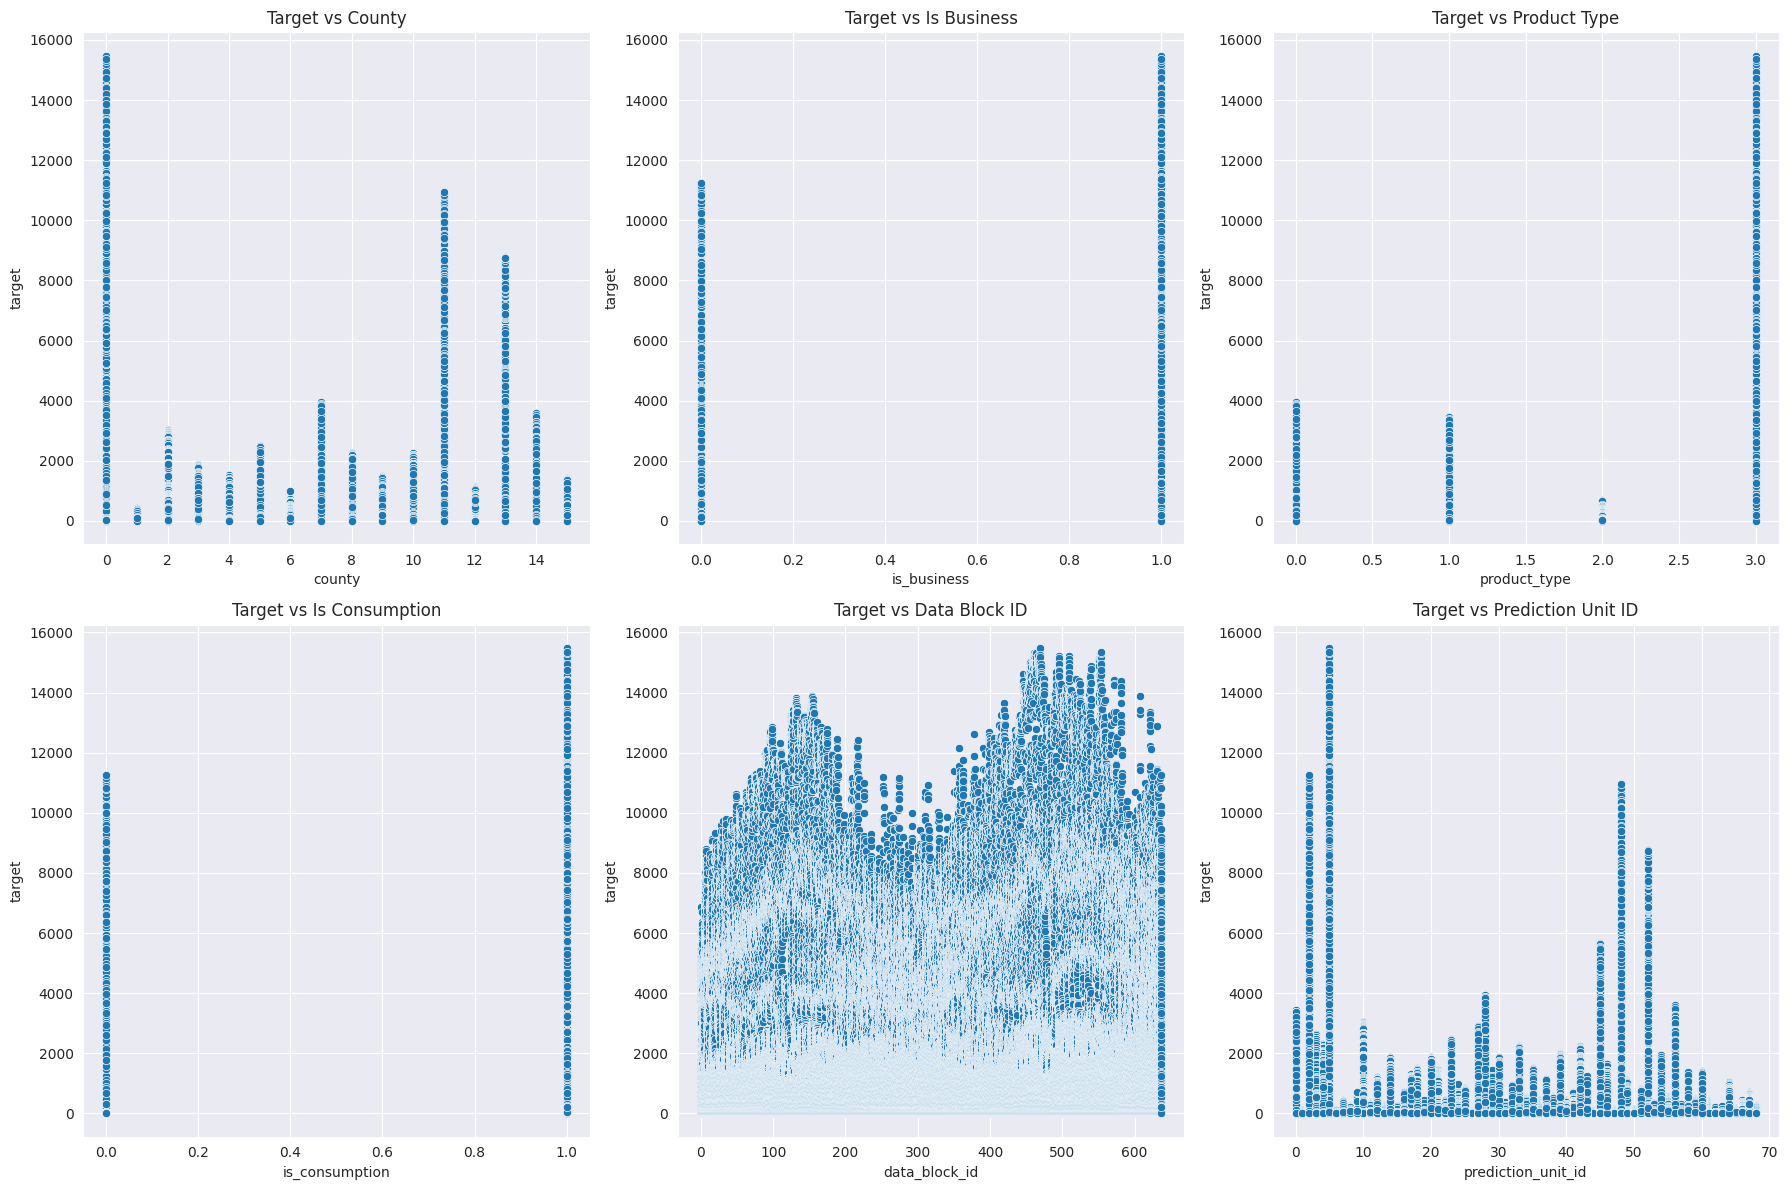

In [19]:
# Preparing plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Scatter plots for 'target' vs other factor variables
sns.scatterplot(data=train, x='county', y='target', ax=axes[0,0])
axes[0,0].set_title('Target vs County')

sns.scatterplot(data=train, x='is_business', y='target', ax=axes[0,1])
axes[0,1].set_title('Target vs Is Business')

sns.scatterplot(data=train, x='product_type', y='target', ax=axes[0,2])
axes[0,2].set_title('Target vs Product Type')

sns.scatterplot(data=train, x='is_consumption', y='target', ax=axes[1,0])
axes[1,0].set_title('Target vs Is Consumption')

sns.scatterplot(data=train, x='data_block_id', y='target', ax=axes[1,1])
axes[1,1].set_title('Target vs Data Block ID')

sns.scatterplot(data=train, x='prediction_unit_id', y='target', ax=axes[1,2])
axes[1,2].set_title('Target vs Prediction Unit ID')

# Adjusting layout
plt.tight_layout()

plt.show()

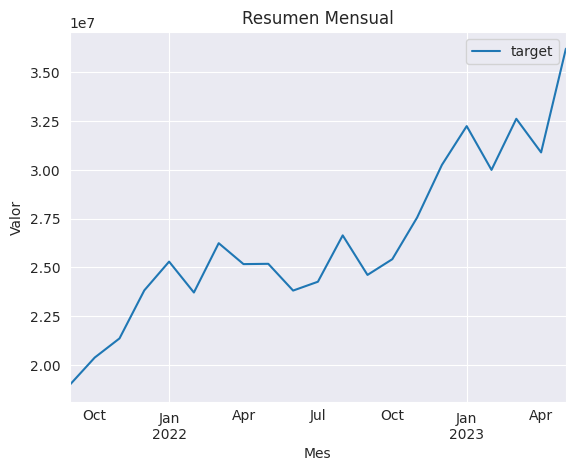

In [45]:
graficar_ts(train, 'datetime', 'target')

## Cliente

El archivo client.csv contiene datos relacionados con instalaciones de algún tipo, posiblemente energéticas, dada la presencia de una columna de 'installed_capacity'. Las columnas presentes en el DataFrame son:

**product_type:** Un identificador numérico para el tipo de producto.
**county:** Un identificador para el condado.
**eic_count:** Número de alguna entidad (quizás instalaciones o equipos).
**installed_capacity:** Capacidad instalada, probablemente medida en alguna unidad de energía o potencia.
**is_business:** Un indicador binario que probablemente distingue entre clientes comerciales (1) y no comerciales (0).
**date:** La fecha de registro o medición.
**data_block_id:** Un identificador para el bloque de datos.

Para realizar un análisis exploratorio de esta data, podemos:

* Revisar estadísticas descriptivas básicas para cada columna numérica.
* Verificar la presencia de valores nulos en el conjunto de datos.
* Analizar la distribución de los datos en las columnas clave.
* Explorar tendencias temporales si la columna 'date' es relevante.
* Investigar las relaciones entre las distintas columnas, como capacidad instalada vs tipo de producto, o capacidad instalada en función de si el cliente es un negocio o no.

Vamos a comenzar con los pasos 1 y 2 para obtener una visión general del conjunto de datos.

In [46]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [54]:
client.date = pd.to_datetime(client.date)

Las estadísticas descriptivas y la verificación de valores nulos nos proporcionan información valiosa sobre el conjunto de datos:

### Estadísticas Descriptivas

**product_type:** Varía de 0 a 3, lo que sugiere que hay cuatro tipos de productos.
**county:** Los valores varían de 0 a 15, indicando 16 condados diferentes.
**eic_count:** El número de entidades varía ampliamente, con un mínimo de 5 y un máximo de 1517.
**installed_capacity:** La capacidad instalada también muestra una gran variación, desde 5.5 hasta 19314.31 (unidad no especificada).
**is_business:** Alrededor del 54% de los registros corresponden a negocios.
**data_block_id:** Varía de 2 a 637, lo que podría indicar diferentes lotes o grupos de datos.

### Valores Nulos
No hay valores nulos en ninguna de las columnas, lo que indica que el conjunto de datos está completo en términos de registros.

Próximos Pasos para el Análisis
Para profundizar en el análisis, podríamos:

Explorar la distribución de 'installed_capacity' para entender mejor cómo se distribuye esta variable.
Examinar cómo varía 'installed_capacity' en función del tipo de producto y si el cliente es un negocio o no.
Analizar las tendencias temporales si las fechas son relevantes, para ver cómo varía la capacidad instalada a lo largo del tiempo.
Procederé con el análisis de la distribución de 'installed_capacity' y cómo varía esta en función de 'product_type' y 'is_business'. También echaré un vistazo a las tendencias temporales. ​

In [48]:
descriptive_stats = client.describe()
# Verificar la presencia de valores nulos en el conjunto de datos
null_values = client.isnull().sum()

descriptive_stats, null_values

(       product_type        county     eic_count  installed_capacity  \
 count  41919.000000  41919.000000  41919.000000        41919.000000   
 mean       1.898996      7.297097     73.345118         1450.771451   
 std        1.081713      4.780750    144.064389         2422.233120   
 min        0.000000      0.000000      5.000000            5.500000   
 25%        1.000000      3.000000     13.000000          321.900000   
 50%        2.000000      7.000000     32.000000          645.200000   
 75%        3.000000     11.000000     70.000000         1567.150000   
 max        3.000000     15.000000   1517.000000        19314.310000   
 
         is_business  data_block_id  
 count  41919.000000   41919.000000  
 mean       0.536773     322.898876  
 std        0.498652     182.075724  
 min        0.000000       2.000000  
 25%        0.000000     167.000000  
 50%        1.000000     324.000000  
 75%        1.000000     480.000000  
 max        1.000000     637.000000  ,
 produc

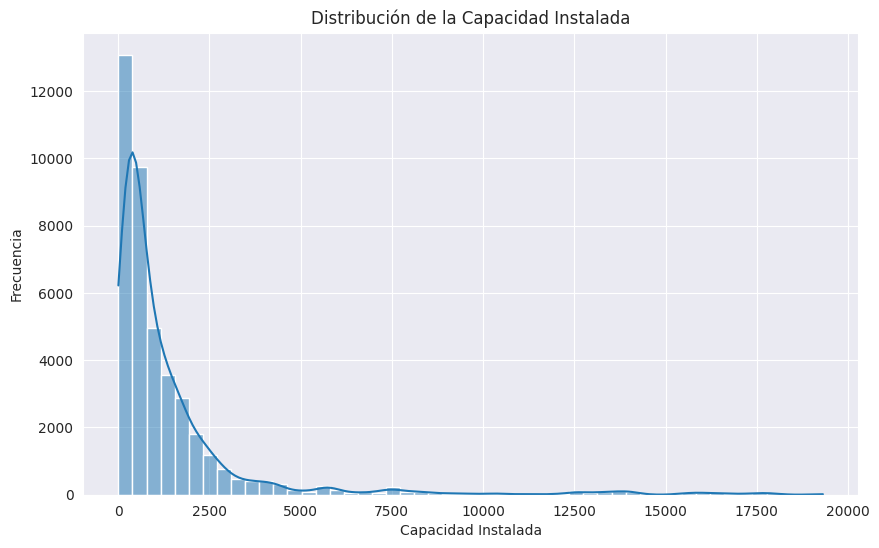

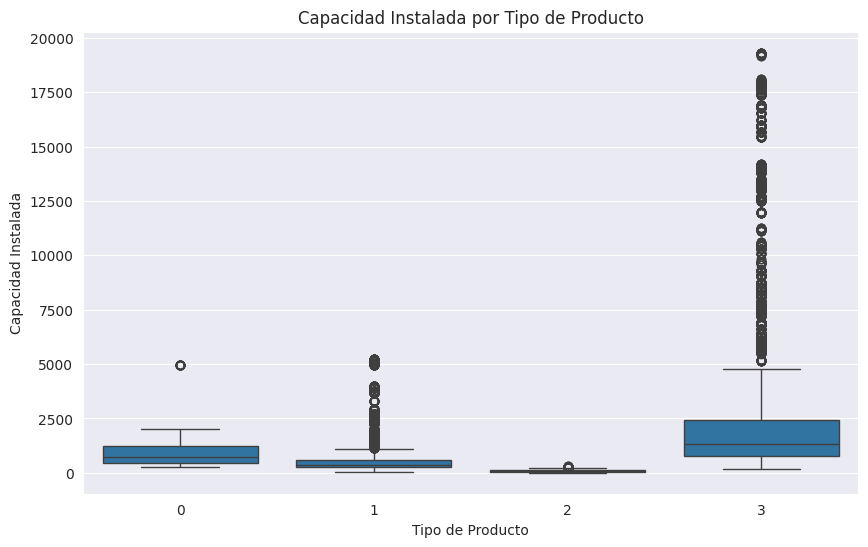

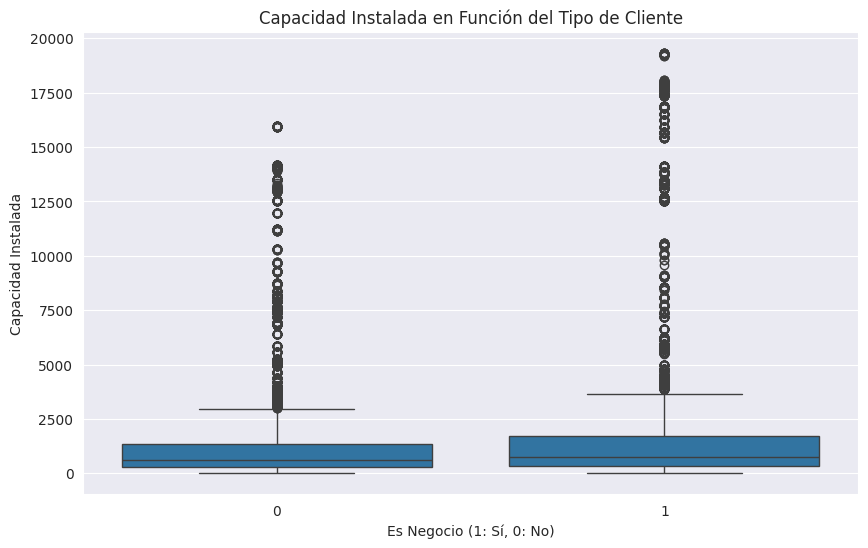

In [50]:
# Distribución de 'installed_capacity'
plt.figure(figsize=(10, 6))
sns.histplot(client['installed_capacity'], bins=50, kde=True)
plt.title('Distribución de la Capacidad Instalada')
plt.xlabel('Capacidad Instalada')
plt.ylabel('Frecuencia')
plt.show()

# Capacidad instalada en función del tipo de producto
plt.figure(figsize=(10, 6))
sns.boxplot(x='product_type', y='installed_capacity', data=client)
plt.title('Capacidad Instalada por Tipo de Producto')
plt.xlabel('Tipo de Producto')
plt.ylabel('Capacidad Instalada')
plt.show()

# Capacidad instalada en función de si es un negocio o no
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_business', y='installed_capacity', data=client)
plt.title('Capacidad Instalada en Función del Tipo de Cliente')
plt.xlabel('Es Negocio (1: Sí, 0: No)')
plt.ylabel('Capacidad Instalada')
plt.show()

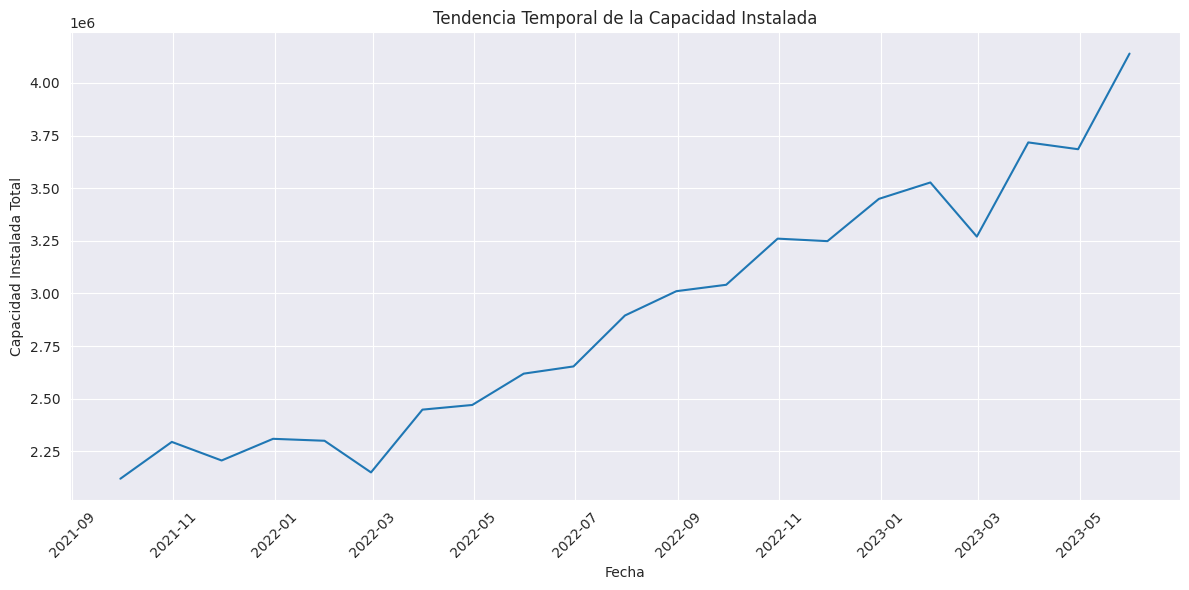

In [55]:
# Tendencias temporales
plt.figure(figsize=(12, 6))
df_resampled = client[['date', 'installed_capacity']].resample('M', on='date').sum()
plt.plot(df_resampled['installed_capacity'])
plt.title('Tendencia Temporal de la Capacidad Instalada')
plt.xlabel('Fecha')
plt.ylabel('Capacidad Instalada Total')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()